Epoch 50, Loss: 0.00013
Epoch 100, Loss: 0.00010
Epoch 150, Loss: 0.00007
Epoch 200, Loss: 0.00009
[NN-based T(y)] Alignment Score: 0.5988


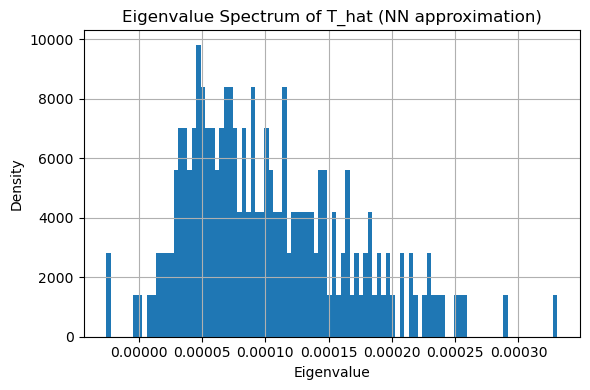

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate data samples and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements: t11, t12, t22
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Construct true symmetric zzᵀ matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)      # d × 1
        T_i = T_y[i]                  # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # Kronecker structure: (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract estimated signal subspace W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 500
    alpha = 5
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network to approximate E[zzᵀ | y]
    model = train_T_net(y, zzT)

    # Construct spectral matrix and estimate subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Evaluate subspace alignment
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.000002
Epoch 100, Loss: 0.000002
Epoch 150, Loss: 0.000002
Epoch 200, Loss: 0.000002
Epoch 250, Loss: 0.000002
Epoch 300, Loss: 0.000002
[NN-based T(y)] Alignment Score: 0.0294
Top eigenvalue: 0.0000


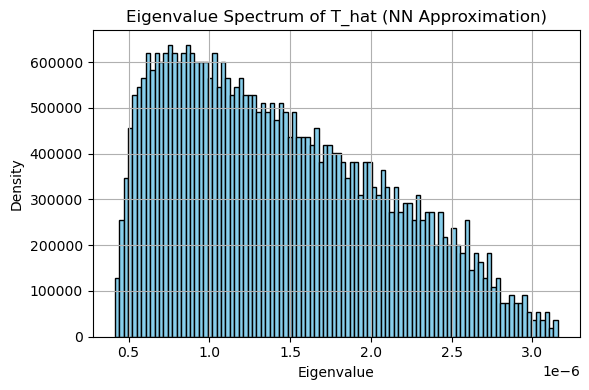

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)  # Ensure orthonormal columns
    return W

# Generate synthetic data and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)  # Normalized scaling
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]  # Link: g(z1, z2) = z1 * z2
    zzT = np.array([np.outer(z, z) for z in Z])  # Per-sample zzᵀ matrices
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11, t12, t22 = out[:, 0], out[:, 1], out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet(hidden_dim=64)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22)
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        running_loss = 0.0
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Construct true symmetric zzᵀ matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.6f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)    # (d, 1)
        T_i = T_y[i]                # (2, 2)
        T_hat += np.kron(T_i, xi @ xi.T)
    return T_hat / n  # Normalization

# Extract estimated subspace W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]  # Select eigenvectors for largest eigenvalues
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 5000
    alpha = 5
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network
    model = train_T_net(y, zzT, epochs=300, lr=1e-3)

    # Build spectral matrix and perform eigen-decomposition
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Evaluate subspace alignment
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")
    print(f"Top eigenvalue: {eigvals[-1]:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True, color='skyblue', edgecolor='k')
    plt.title("Eigenvalue Spectrum of T_hat (NN Approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


### Binning y: discretize the continuous y into several bins and compute statistics for each bin.

Epoch 50, Loss: 0.00000
Epoch 100, Loss: 0.00000
Epoch 150, Loss: 0.00000
Epoch 200, Loss: 0.00000
[NN-based T(y)] Alignment Score: 0.3212


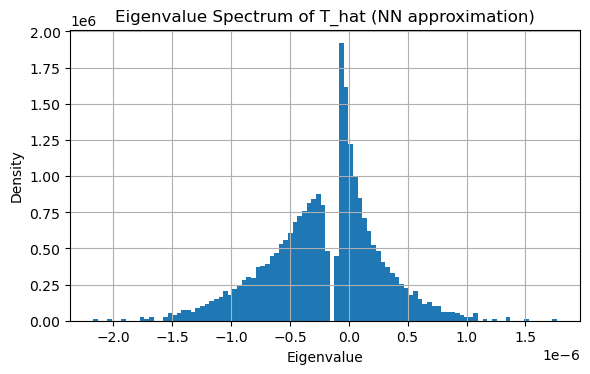

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate synthetic data and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22)
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # True symmetric zzᵀ matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)
        T_i = T_y[i]
        kron = np.kron(T_i, xi @ xi.T)
        T_hat += kron
    return T_hat / n

# Extract estimated subspace W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 5000
    alpha = 5
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Evaluate subspace alignment
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00005
Epoch 100, Loss: 0.00007
Epoch 150, Loss: 0.00005
Epoch 200, Loss: 0.00004
[NN-based T(y)] Alignment Score: 0.3917


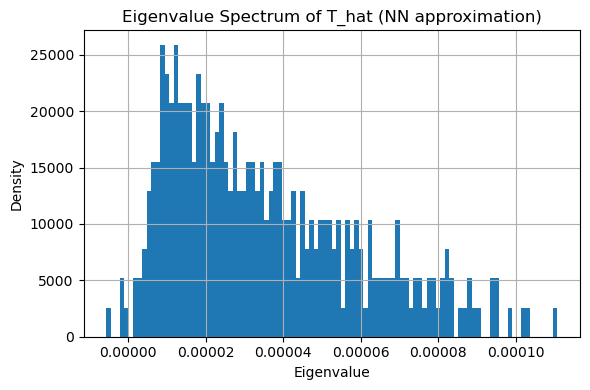

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate samples and nonlinear response
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to predict the entries of zzᵀ
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22) from zzᵀ
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Shape: (batch, 2, 2)

            # Ground-truth symmetric matrices (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model


# Build spectral matrix T_hat
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        T_i = T_y[i]              # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract W_hat from the spectral matrix
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main routine
def main():
    n = 500
    alpha = 3
    d = int(n / alpha)
    p = 2

    # Data generation
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train the network
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Alignment metric
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Eigenvalue spectrum visualization
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00003
Epoch 100, Loss: 0.00002
Epoch 150, Loss: 0.00002
Epoch 200, Loss: 0.00002
[NN-based T(y)] Alignment Score: 0.2332


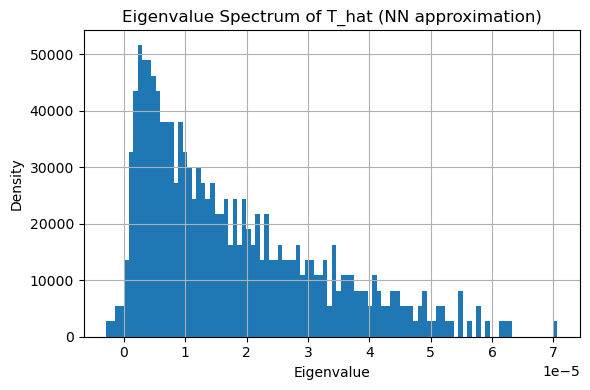

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate samples and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22) from zzᵀ
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Ground-truth symmetric matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        T_i = T_y[i]              # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 500
    alpha = 2
    d = int(n / alpha)
    p = 2

    # Generate data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train network to approximate T(y)
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract estimated subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Compute subspace alignment
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00001
Epoch 100, Loss: 0.00001
Epoch 150, Loss: 0.00001
Epoch 200, Loss: 0.00001
[NN-based T(y)] Alignment Score: 0.1924


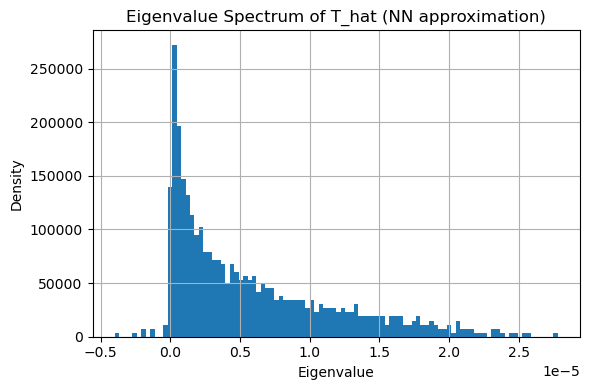

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate samples and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22) from zzᵀ
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Construct ground-truth symmetric matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        T_i = T_y[i]              # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 500
    alpha = 1.2
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract estimated subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Compute alignment score
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00092
Epoch 100, Loss: 0.00057
Epoch 150, Loss: 0.00089
Epoch 200, Loss: 0.00051
[NN-based T(y)] Alignment Score: 0.8994


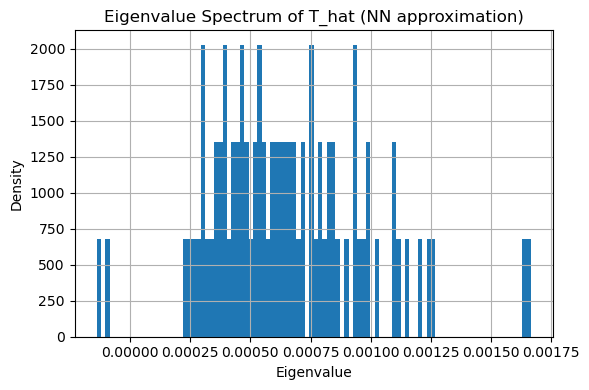

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate samples and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22) from zzᵀ
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Construct ground-truth symmetric matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        T_i = T_y[i]              # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 500
    alpha = 12
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract estimated subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Compute alignment score
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00062
Epoch 100, Loss: 0.00051
Epoch 150, Loss: 0.00025
Epoch 200, Loss: 0.00039
[NN-based T(y)] Alignment Score: 0.7404


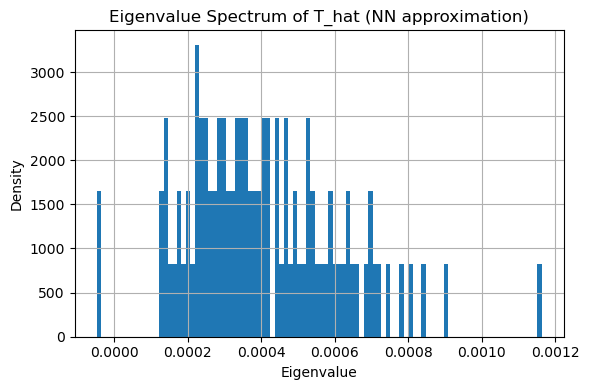

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate samples and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22) from zzᵀ
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Construct ground-truth symmetric matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        T_i = T_y[i]              # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 500
    alpha = 10
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract estimated subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Compute alignment score
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00162
Epoch 100, Loss: 0.00197
Epoch 150, Loss: 0.00148
Epoch 200, Loss: 0.00132
[NN-based T(y)] Alignment Score: 0.8880


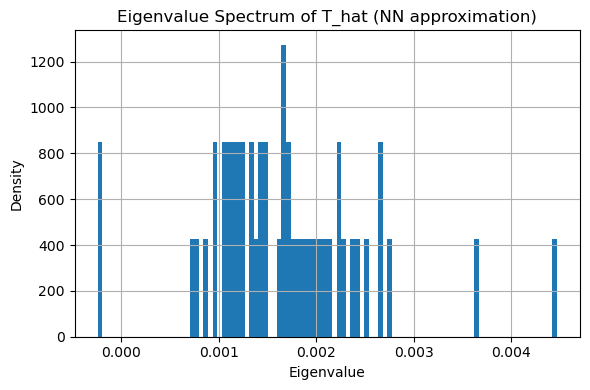

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate samples and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22) from zzᵀ
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Construct ground-truth symmetric matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        T_i = T_y[i]              # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 500
    alpha = 20
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract estimated subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Compute alignment score
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00037
Epoch 100, Loss: 0.00018
Epoch 150, Loss: 0.00023
Epoch 200, Loss: 0.00035
[NN-based T(y)] Alignment Score: 0.7330


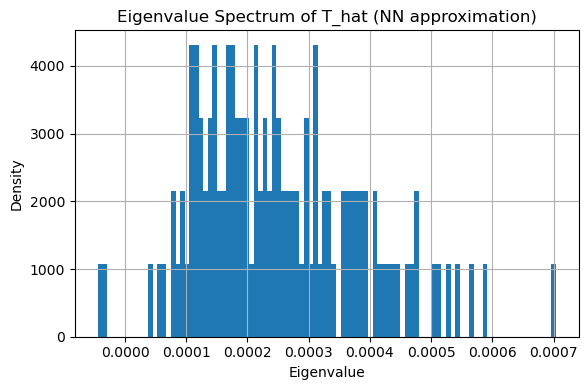

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate ground-truth signal subspace W*
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# Generate samples and nonlinear response y = z1 * z2
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# Two-layer MLP to approximate E[zzᵀ | y]
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Outputs t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # Shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # Shape: (n, 2, 2)
        return T

# Train neural network to approximate E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Extract independent elements (t11, t12, t22) from zzᵀ
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # Shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # Predicted T(y): (batch, 2, 2)

            # Construct ground-truth symmetric matrices: (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model

# Build symmetric spectral matrix T_hat using learned T(y)
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # Shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d × 1
        T_i = T_y[i]              # (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # (2d, 2d)
        T_hat += kron
    return T_hat / n

# Extract W_hat from spectral decomposition
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# Compute subspace alignment score via principal angles
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Main workflow
def main():
    n = 500
    alpha = 8
    d = int(n / alpha)
    p = 2

    # Generate synthetic data
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # Train neural network
    model = train_T_net(y, zzT)

    # Build spectral matrix and extract estimated subspace
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # Compute alignment score
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # Visualize eigenvalue spectrum
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 50, Loss: 0.00008
Epoch 100, Loss: 0.00007
Epoch 150, Loss: 0.00008
Epoch 200, Loss: 0.00009
[NN-based T(y)] Alignment Score: 0.5472


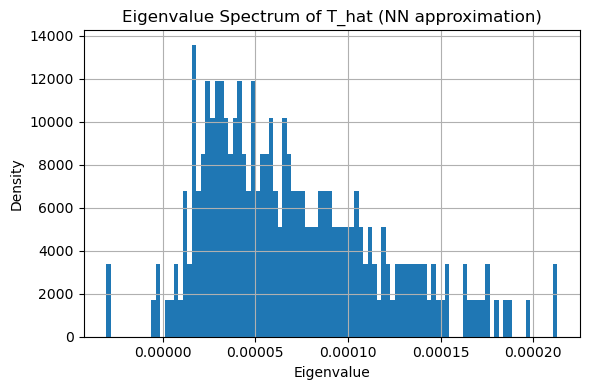

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import eigh, qr
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

# 构造 Ground Truth 子空间
def generate_ground_truth(d=100, p=2):
    W = np.random.randn(d, p)
    W, _ = np.linalg.qr(W)
    return W

# 生成样本数据
def generate_data(W_star, n):
    d, p = W_star.shape
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    zzT = np.array([np.outer(z, z) for z in Z])
    return X, y, zzT

# 简单两层 MLP，用于预测 zz^T 的每个元素
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # 输出 t11, t12, t22
        )
    
    def forward(self, y):
        out = self.net(y)  # shape: (n, 3)
        t11 = out[:, 0]
        t12 = out[:, 1]
        t22 = out[:, 2]
        T = torch.stack([
            torch.stack([t11, t12], dim=1),
            torch.stack([t12, t22], dim=1)
        ], dim=1)  # shape: (n, 2, 2)
        return T

# 训练神经网络以拟合 E[zzᵀ | y]
def train_T_net(y_train, zzT_train, epochs=200, lr=1e-3, batch_size=128):
    model = TNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # 从 zzT 中提取自由元素 (t11, t12, t22)
    t11 = zzT_train[:, 0, 0]
    t12 = zzT_train[:, 0, 1]
    t22 = zzT_train[:, 1, 1]
    zzT_vec = np.stack([t11, t12, t22], axis=1)  # shape: (n, 3)

    dataset = TensorDataset(torch.tensor(y_train[:, None], dtype=torch.float32),
                            torch.tensor(zzT_vec, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for y_batch, zz_batch in loader:
            T_pred = model(y_batch)  # shape: (batch, 2, 2)

            # 构造真实对称矩阵 (batch, 2, 2)
            zz_true = torch.stack([
                torch.stack([zz_batch[:, 0], zz_batch[:, 1]], dim=1),
                torch.stack([zz_batch[:, 1], zz_batch[:, 2]], dim=1)
            ], dim=1)

            loss = loss_fn(T_pred, zz_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")
    return model


# 构造谱矩阵 T_hat
def build_T_hat(X, y, model):
    n, d = X.shape
    with torch.no_grad():
        T_y = model(torch.tensor(y[:, None], dtype=torch.float32)).numpy()  # shape: (n, 2, 2)

    T_hat = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i].reshape(-1, 1)  # d×1
        T_i = T_y[i]  # shape: (2, 2)
        kron = np.kron(T_i, xi @ xi.T)  # shape: (2d, 2d)
        T_hat += kron
    return T_hat / n

# 从谱矩阵提取 W_hat
def extract_W_hat(T_hat, d, p=2):
    eigvals, eigvecs = eigh(T_hat)
    W_hat = np.zeros((d, p))
    for j in range(p):
        v = eigvecs[:, -(j + 1)]
        W_hat[:, j] = v[:d]
    return W_hat, eigvals

# 计算对齐度
def compute_alignment(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# 主程序
def main():
    n = 500
    alpha = 4.1
    d = int(n / alpha)
    p = 2

    # 数据生成
    W_star = generate_ground_truth(d, p)
    X, y, zzT = generate_data(W_star, n)

    # 训练网络
    model = train_T_net(y, zzT)

    # 构建谱矩阵并提取子空间
    T_hat = build_T_hat(X, y, model)
    W_hat, eigvals = extract_W_hat(T_hat, d, p)

    # 对齐度量
    score = compute_alignment(W_hat, W_star)
    print(f"[NN-based T(y)] Alignment Score: {score:.4f}")

    # 谱图可视化
    plt.figure(figsize=(6, 4))
    plt.hist(eigvals, bins=100, density=True)
    plt.title("Eigenvalue Spectrum of T_hat (NN approximation)")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
